# BCE vs BCEWithLogitsLoss

Comparing numerical stability and training behavior between:
1. `sigmoid → BCELoss`
2. `BCEWithLogitsLoss` (combined operation)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")

Using device: cpu


## Loss Function Analysis

Probing BCE vs BCEWithLogitsLoss behavior across different logit values.

In [4]:
# Define loss functions with no reduction
bce_loss = nn.BCELoss(reduction='none')
bce_with_logits_loss = nn.BCEWithLogitsLoss(reduction='none')

# Range of logits to test
logits = torch.linspace(-15, 15, 1000)

# Targets
target_0 = torch.zeros_like(logits)
target_1 = torch.ones_like(logits)

# Compute probabilities for BCELoss
probs = torch.sigmoid(logits)

# Compute losses for target=1
loss_bce_t1 = bce_loss(probs, target_1)
loss_bcewl_t1 = bce_with_logits_loss(logits, target_1)

# Compute losses for target=0
loss_bce_t0 = bce_loss(probs, target_0)
loss_bcewl_t0 = bce_with_logits_loss(logits, target_0)

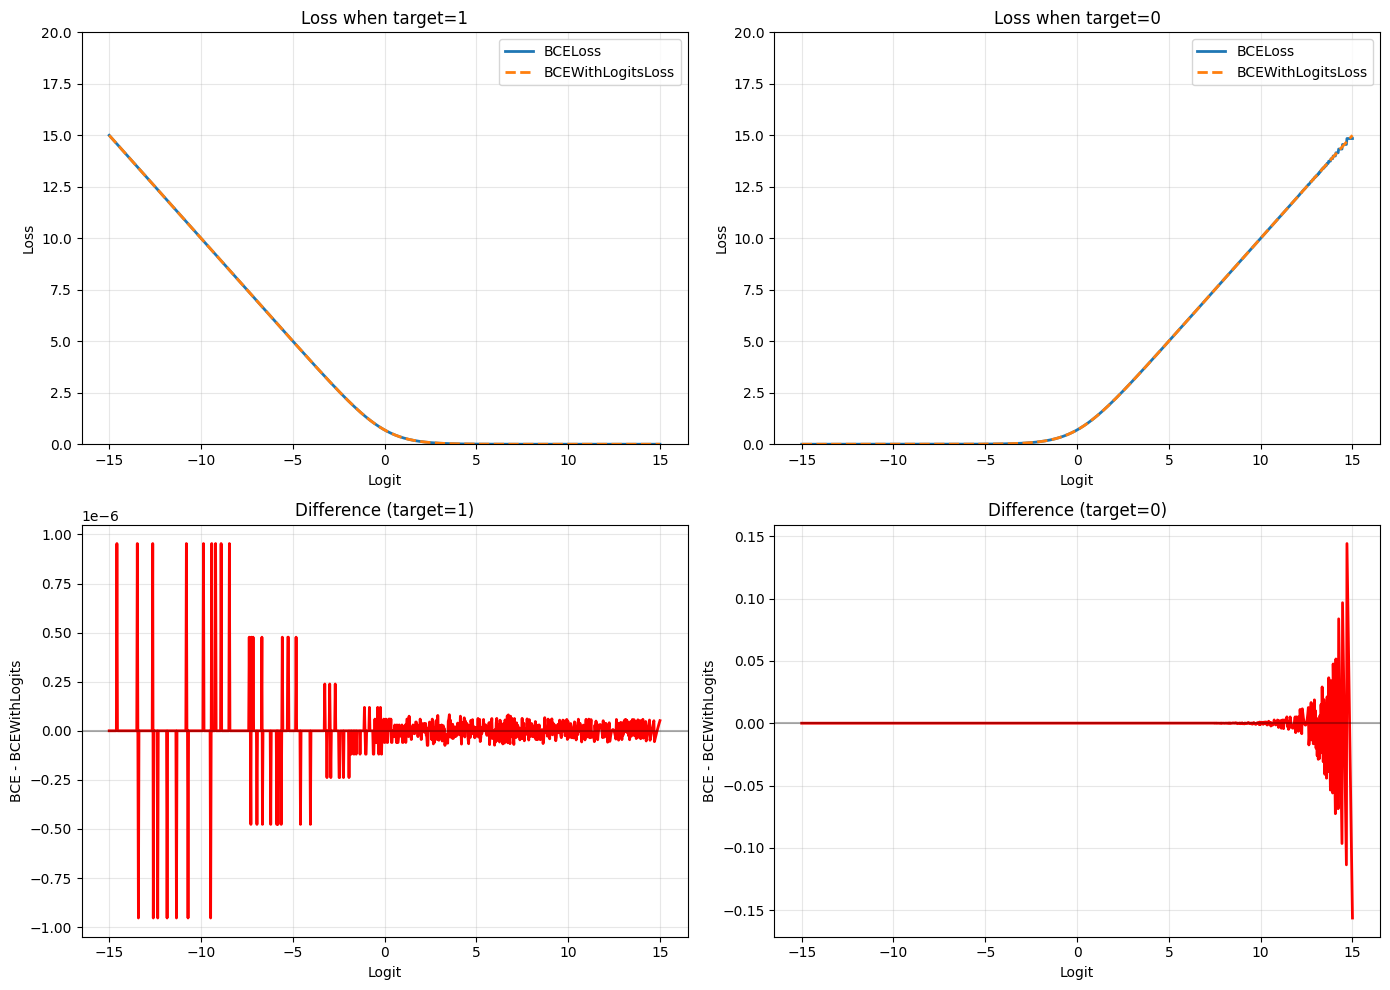

Max absolute difference (target=1): 0.000001
Max absolute difference (target=0): 0.156227


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Loss values for target=1
ax = axes[0, 0]
ax.plot(logits.numpy(), loss_bce_t1.numpy(), label='BCELoss', linewidth=2)
ax.plot(logits.numpy(), loss_bcewl_t1.numpy(), '--', label='BCEWithLogitsLoss', linewidth=2)
ax.set_xlabel('Logit')
ax.set_ylabel('Loss')
ax.set_title('Loss when target=1')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 20)

# Plot 2: Loss values for target=0
ax = axes[0, 1]
ax.plot(logits.numpy(), loss_bce_t0.numpy(), label='BCELoss', linewidth=2)
ax.plot(logits.numpy(), loss_bcewl_t0.numpy(), '--', label='BCEWithLogitsLoss', linewidth=2)
ax.set_xlabel('Logit')
ax.set_ylabel('Loss')
ax.set_title('Loss when target=0')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 20)

# Plot 3: Difference between the two loss functions (target=1)
ax = axes[1, 0]
diff_t1 = (loss_bce_t1 - loss_bcewl_t1).numpy()
ax.plot(logits.numpy(), diff_t1, color='red', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Logit')
ax.set_ylabel('BCE - BCEWithLogits')
ax.set_title('Difference (target=1)')
ax.grid(True, alpha=0.3)

# Plot 4: Difference between the two loss functions (target=0)
ax = axes[1, 1]
diff_t0 = (loss_bce_t0 - loss_bcewl_t0).numpy()
ax.plot(logits.numpy(), diff_t0, color='red', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Logit')
ax.set_ylabel('BCE - BCEWithLogits')
ax.set_title('Difference (target=0)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary stats
print(f"Max absolute difference (target=1): {np.abs(diff_t1).max():.6f}")
print(f"Max absolute difference (target=0): {np.abs(diff_t0).max():.6f}")

## Gradient Analysis

Compare gradients w.r.t. logits for both loss functions.

In [7]:
def compute_gradients(logit_range, target_val):
    """Compute gradients for both loss functions."""
    grads_bce = []
    grads_bcewl = []
    
    for logit_val in logit_range:
        # BCE: sigmoid -> BCELoss
        logit = torch.tensor([logit_val], requires_grad=True)
        prob = torch.sigmoid(logit)
        target = torch.tensor([target_val], dtype=torch.float64)
        loss = bce_loss(prob, target).sum()
        loss.backward()
        grads_bce.append(logit.grad.item())
        
        # BCEWithLogitsLoss
        logit = torch.tensor([logit_val], requires_grad=True)
        target = torch.tensor([target_val])
        loss = bce_with_logits_loss(logit, target).sum()
        loss.backward()
        grads_bcewl.append(logit.grad.item())
    
    return np.array(grads_bce), np.array(grads_bcewl)

logit_range = np.linspace(-15, 15, 500)
grads_bce_t1, grads_bcewl_t1 = compute_gradients(logit_range, 1.0)
grads_bce_t0, grads_bcewl_t0 = compute_gradients(logit_range, 0.0)

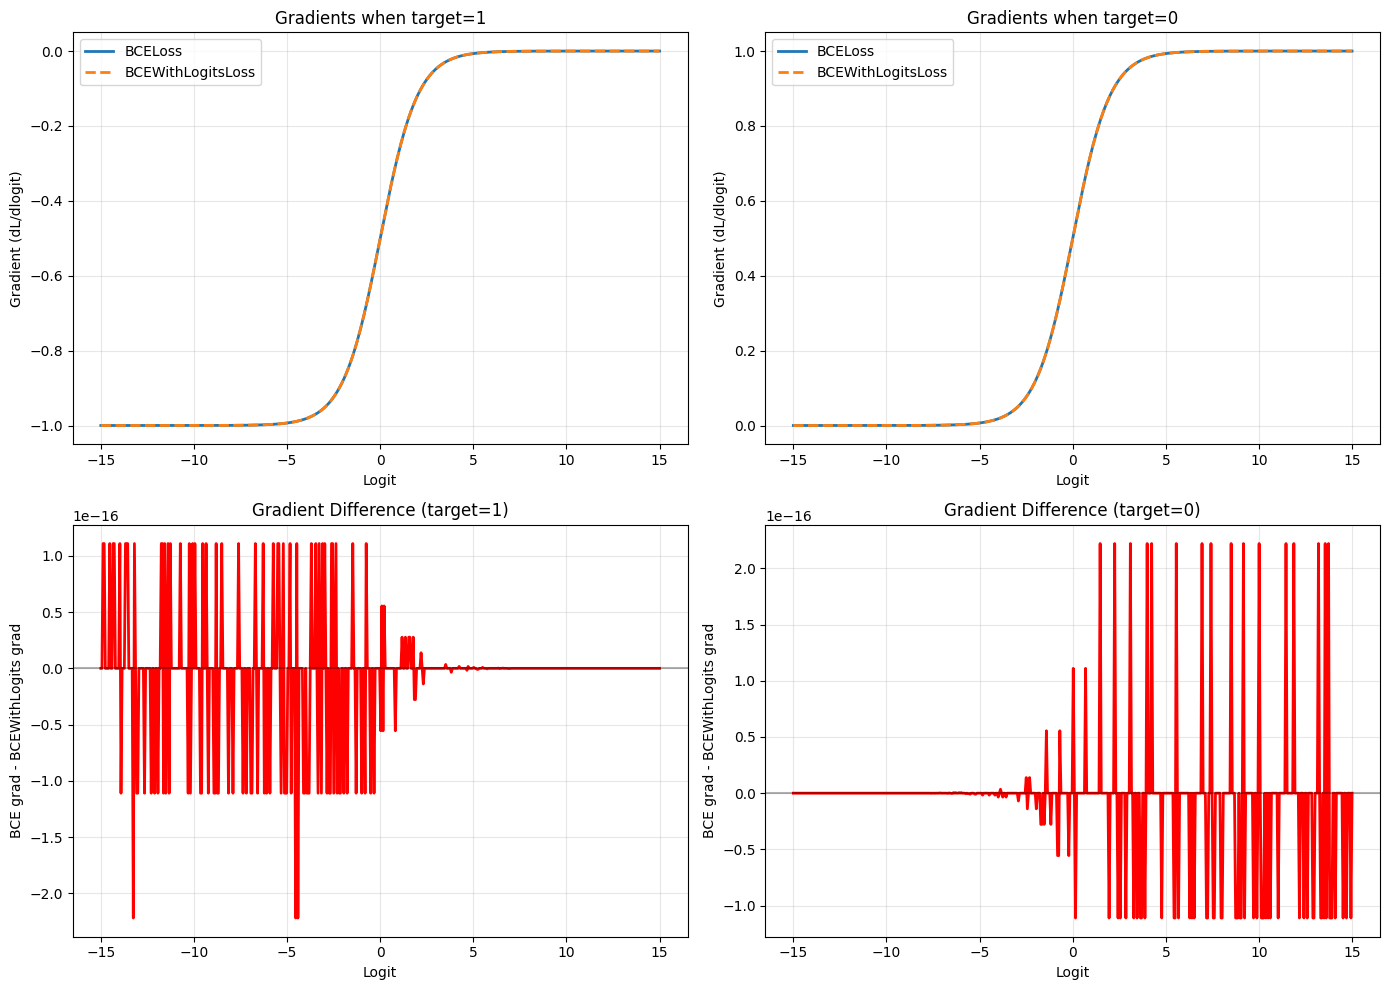

Max absolute gradient difference (target=1): 0.000000
Max absolute gradient difference (target=0): 0.000000


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Gradients for target=1
ax = axes[0, 0]
ax.plot(logit_range, grads_bce_t1, label='BCELoss', linewidth=2)
ax.plot(logit_range, grads_bcewl_t1, '--', label='BCEWithLogitsLoss', linewidth=2)
ax.set_xlabel('Logit')
ax.set_ylabel('Gradient (dL/dlogit)')
ax.set_title('Gradients when target=1')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Gradients for target=0
ax = axes[0, 1]
ax.plot(logit_range, grads_bce_t0, label='BCELoss', linewidth=2)
ax.plot(logit_range, grads_bcewl_t0, '--', label='BCEWithLogitsLoss', linewidth=2)
ax.set_xlabel('Logit')
ax.set_ylabel('Gradient (dL/dlogit)')
ax.set_title('Gradients when target=0')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Gradient difference (target=1)
ax = axes[1, 0]
grad_diff_t1 = grads_bce_t1 - grads_bcewl_t1
ax.plot(logit_range, grad_diff_t1, color='red', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Logit')
ax.set_ylabel('BCE grad - BCEWithLogits grad')
ax.set_title('Gradient Difference (target=1)')
ax.grid(True, alpha=0.3)

# Plot 4: Gradient difference (target=0)
ax = axes[1, 1]
grad_diff_t0 = grads_bce_t0 - grads_bcewl_t0
ax.plot(logit_range, grad_diff_t0, color='red', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Logit')
ax.set_ylabel('BCE grad - BCEWithLogits grad')
ax.set_title('Gradient Difference (target=0)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max absolute gradient difference (target=1): {np.abs(grad_diff_t1).max():.6f}")
print(f"Max absolute gradient difference (target=0): {np.abs(grad_diff_t0).max():.6f}")

## Extreme Value Behavior

Testing what happens at very large/small logits where numerical issues arise.

In [9]:
# Test extreme logit values
extreme_logits = torch.tensor([-100., -50., -20., -10., 0., 10., 20., 50., 100.])

print("=" * 80)
print("EXTREME VALUE ANALYSIS")
print("=" * 80)

for target_val in [0., 1.]:
    target = torch.full_like(extreme_logits, target_val)
    probs = torch.sigmoid(extreme_logits)
    
    print(f"\n{'='*40}")
    print(f"Target = {target_val}")
    print(f"{'='*40}")
    print(f"{'Logit':>10} | {'Prob':>12} | {'BCE':>12} | {'BCEwLogits':>12} | {'Diff':>12}")
    print("-" * 70)
    
    for i, logit in enumerate(extreme_logits):
        prob = probs[i]
        
        # BCELoss
        try:
            loss_bce = bce_loss(prob.unsqueeze(0), target[i].unsqueeze(0)).item()
        except:
            loss_bce = float('nan')
        
        # BCEWithLogitsLoss
        loss_bcewl = bce_with_logits_loss(logit.unsqueeze(0), target[i].unsqueeze(0)).item()
        
        diff = loss_bce - loss_bcewl if not np.isnan(loss_bce) else float('nan')
        
        print(f"{logit.item():>10.1f} | {prob.item():>12.6e} | {loss_bce:>12.4f} | {loss_bcewl:>12.4f} | {diff:>12.6f}")

EXTREME VALUE ANALYSIS

Target = 0.0
     Logit |         Prob |          BCE |   BCEwLogits |         Diff
----------------------------------------------------------------------
    -100.0 | 0.000000e+00 |       0.0000 |       0.0000 |     0.000000
     -50.0 | 1.928750e-22 |       0.0000 |       0.0000 |     0.000000
     -20.0 | 2.061154e-09 |       0.0000 |       0.0000 |     0.000000
     -10.0 | 4.539787e-05 |       0.0000 |       0.0000 |    -0.000000
       0.0 | 5.000000e-01 |       0.6931 |       0.6931 |     0.000000
      10.0 | 9.999546e-01 |       9.9996 |      10.0000 |    -0.000460
      20.0 | 1.000000e+00 |     100.0000 |      20.0000 |    80.000000
      50.0 | 1.000000e+00 |     100.0000 |      50.0000 |    50.000000
     100.0 | 1.000000e+00 |     100.0000 |     100.0000 |     0.000000

Target = 1.0
     Logit |         Prob |          BCE |   BCEwLogits |         Diff
----------------------------------------------------------------------
    -100.0 | 0.000000e+00 

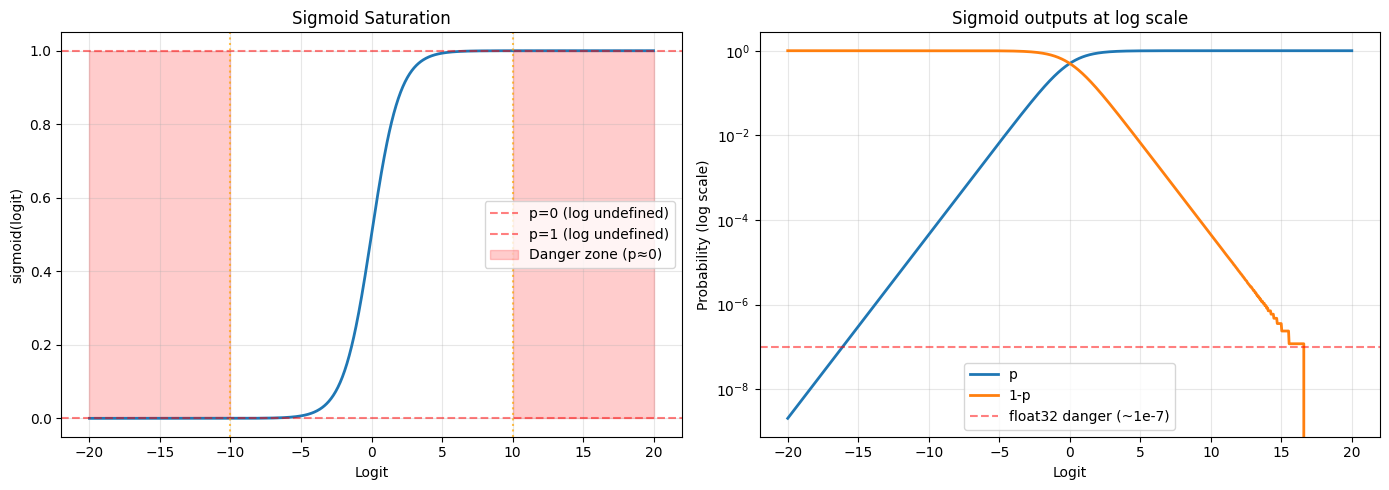


Sigmoid saturation points (float32):
  sigmoid(-17) = 4.14e-08
  sigmoid(-16) = 1.13e-07
  sigmoid(16)  = 1.19e-07 (1-p)
  sigmoid(17)  = 0.00e+00 (1-p)


In [10]:
# Visualize sigmoid saturation regions
logits_fine = torch.linspace(-20, 20, 1000)
probs_fine = torch.sigmoid(logits_fine)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sigmoid curve
ax = axes[0]
ax.plot(logits_fine.numpy(), probs_fine.numpy(), linewidth=2)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='p=0 (log undefined)')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='p=1 (log undefined)')
ax.axvline(x=-10, color='orange', linestyle=':', alpha=0.7)
ax.axvline(x=10, color='orange', linestyle=':', alpha=0.7)
ax.fill_between(logits_fine.numpy(), 0, 1, where=(logits_fine.numpy() < -10), alpha=0.2, color='red', label='Danger zone (p≈0)')
ax.fill_between(logits_fine.numpy(), 0, 1, where=(logits_fine.numpy() > 10), alpha=0.2, color='red')
ax.set_xlabel('Logit')
ax.set_ylabel('sigmoid(logit)')
ax.set_title('Sigmoid Saturation')
ax.legend(loc='center right')
ax.grid(True, alpha=0.3)

# Log scale to see the extremes
ax = axes[1]
ax.semilogy(logits_fine.numpy(), probs_fine.numpy(), label='p', linewidth=2)
ax.semilogy(logits_fine.numpy(), 1 - probs_fine.numpy(), label='1-p', linewidth=2)
ax.axhline(y=1e-7, color='red', linestyle='--', alpha=0.5, label='float32 danger (~1e-7)')
ax.set_xlabel('Logit')
ax.set_ylabel('Probability (log scale)')
ax.set_title('Sigmoid outputs at log scale')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find where sigmoid saturates
print(f"\nSigmoid saturation points (float32):")
print(f"  sigmoid(-17) = {torch.sigmoid(torch.tensor(-17.)).item():.2e}")
print(f"  sigmoid(-16) = {torch.sigmoid(torch.tensor(-16.)).item():.2e}")
print(f"  sigmoid(16)  = {1 - torch.sigmoid(torch.tensor(16.)).item():.2e} (1-p)")
print(f"  sigmoid(17)  = {1 - torch.sigmoid(torch.tensor(17.)).item():.2e} (1-p)")

## Mathematical Formulation

**BCELoss formula:**
$$L = -[y \cdot \log(p) + (1-y) \cdot \log(1-p)]$$

Problem: When $p \to 0$ or $p \to 1$, we compute $\log(0) = -\infty$

**BCEWithLogitsLoss formula (numerically stable):**
$$L = \max(x, 0) - x \cdot y + \log(1 + e^{-|x|})$$

This avoids computing $\log(\sigma(x))$ directly by using the log-sum-exp trick.

In [11]:
# Verify the stable formula manually
def stable_bce_with_logits(logit, target):
    """Manual implementation of the numerically stable formula."""
    return torch.clamp(logit, min=0) - logit * target + torch.log(1 + torch.exp(-torch.abs(logit)))

# Test at various logits
test_logits = torch.tensor([-5., -1., 0., 1., 5.])
test_targets = torch.tensor([1., 0., 1., 0., 1.])

print("Verifying stable formula matches BCEWithLogitsLoss:")
print(f"{'Logit':>8} | {'Target':>8} | {'Manual':>12} | {'PyTorch':>12} | {'Match':>8}")
print("-" * 60)

for logit, target in zip(test_logits, test_targets):
    manual = stable_bce_with_logits(logit, target).item()
    pytorch = bce_with_logits_loss(logit.unsqueeze(0), target.unsqueeze(0)).item()
    match = "Yes" if abs(manual - pytorch) < 1e-6 else "No"
    print(f"{logit.item():>8.1f} | {target.item():>8.1f} | {manual:>12.6f} | {pytorch:>12.6f} | {match:>8}")

Verifying stable formula matches BCEWithLogitsLoss:
   Logit |   Target |       Manual |      PyTorch |    Match
------------------------------------------------------------
    -5.0 |      1.0 |     5.006715 |     5.006715 |      Yes
    -1.0 |      0.0 |     0.313262 |     0.313262 |      Yes
     0.0 |      1.0 |     0.693147 |     0.693147 |      Yes
     1.0 |      0.0 |     1.313262 |     1.313262 |      Yes
     5.0 |      1.0 |     0.006715 |     0.006715 |      Yes


## The Asymmetry Problem

BCELoss behaves asymmetrically for the same magnitude of logit error due to float32 precision.

In [12]:
# Demonstrate the float32 asymmetry
print("=" * 70)
print("FLOAT32 ASYMMETRY IN SIGMOID")
print("=" * 70)

test_logits = [10, 15, 17, 20, 50]

print(f"\n{'Logit':>6} | {'sigmoid(x)':>15} | {'sigmoid(-x)':>15} | {'1-sigmoid(x)':>15}")
print("-" * 60)

for x in test_logits:
    pos = torch.sigmoid(torch.tensor(float(x)))
    neg = torch.sigmoid(torch.tensor(float(-x)))
    one_minus = 1.0 - pos
    print(f"{x:>6} | {pos.item():>15.10f} | {neg.item():>15.10e} | {one_minus.item():>15.10e}")

print("\n" + "=" * 70)
print("CONSEQUENCE FOR BCE LOSS (same magnitude logit error)")
print("=" * 70)
print(f"\n{'Logit':>6} | {'Target':>6} | {'BCE Loss':>12} | {'BCEwLogits':>12} | {'Notes'}")
print("-" * 75)

for x in [10, 15, 17, 20]:
    logit_pos = torch.tensor([float(x)])
    logit_neg = torch.tensor([float(-x)])
    
    # Wrong prediction: target=0 but logit is positive (predicting 1)
    p_pos = torch.sigmoid(logit_pos)
    loss_bce_t0 = bce_loss(p_pos, torch.tensor([0.])).item()
    loss_bcewl_t0 = bce_with_logits_loss(logit_pos, torch.tensor([0.])).item()
    
    # Wrong prediction: target=1 but logit is negative (predicting 0)  
    p_neg = torch.sigmoid(logit_neg)
    loss_bce_t1 = bce_loss(p_neg, torch.tensor([1.])).item()
    loss_bcewl_t1 = bce_with_logits_loss(logit_neg, torch.tensor([1.])).item()
    
    note_t0 = "CLAMPED!" if loss_bce_t0 > 50 else ""
    note_t1 = "CLAMPED!" if loss_bce_t1 > 50 else ""
    
    print(f"{x:>+6} | {'0':>6} | {loss_bce_t0:>12.4f} | {loss_bcewl_t0:>12.4f} | {note_t0}")
    print(f"{-x:>+6} | {'1':>6} | {loss_bce_t1:>12.4f} | {loss_bcewl_t1:>12.4f} | {note_t1}")
    print("-" * 75)

FLOAT32 ASYMMETRY IN SIGMOID

 Logit |      sigmoid(x) |     sigmoid(-x) |    1-sigmoid(x)
------------------------------------------------------------
    10 |    0.9999545813 | 4.5397871872e-05 | 4.5418739319e-05
    15 |    0.9999996424 | 3.0590223332e-07 | 3.5762786865e-07
    17 |    1.0000000000 | 4.1399378148e-08 | 0.0000000000e+00
    20 |    1.0000000000 | 2.0611536922e-09 | 0.0000000000e+00
    50 |    1.0000000000 | 1.9287498934e-22 | 0.0000000000e+00

CONSEQUENCE FOR BCE LOSS (same magnitude logit error)

 Logit | Target |     BCE Loss |   BCEwLogits | Notes
---------------------------------------------------------------------------
   +10 |      0 |       9.9996 |      10.0000 | 
   -10 |      1 |      10.0000 |      10.0000 | 
---------------------------------------------------------------------------
   +15 |      0 |      14.8438 |      15.0000 | 
   -15 |      1 |      15.0000 |      15.0000 | 
---------------------------------------------------------------------------

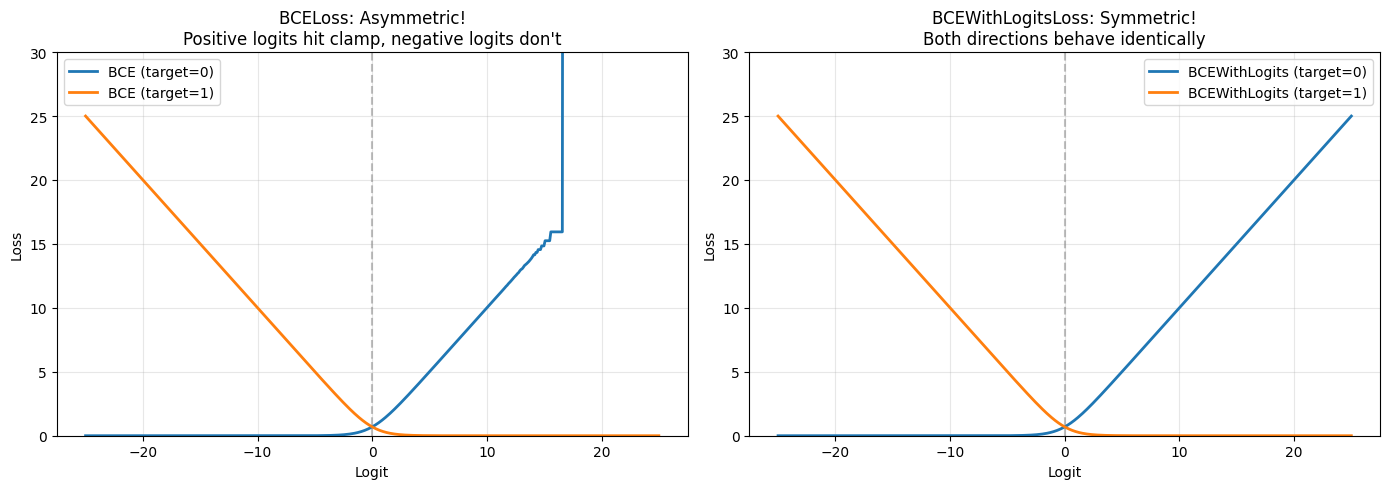


Asymmetry check (loss for |logit|=20):
  BCE: target=0, logit=+20: 100.0000
  BCE: target=1, logit=-20: 20.0000
  BCEWithLogits: target=0, logit=+20: 20.0000
  BCEWithLogits: target=1, logit=-20: 20.0000


In [13]:
# Visualize the asymmetry
logits_asym = torch.linspace(-25, 25, 500)
target_0 = torch.zeros_like(logits_asym)
target_1 = torch.ones_like(logits_asym)
probs = torch.sigmoid(logits_asym)

# BCE losses
loss_bce_wrong_for_t0 = bce_loss(probs, target_0).numpy()  # positive logit, target=0
loss_bce_wrong_for_t1 = bce_loss(probs, target_1).numpy()  # negative logit, target=1

# BCEWithLogits losses  
loss_bcewl_t0 = bce_with_logits_loss(logits_asym, target_0).numpy()
loss_bcewl_t1 = bce_with_logits_loss(logits_asym, target_1).numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot BCE asymmetry
ax = axes[0]
ax.plot(logits_asym.numpy(), loss_bce_wrong_for_t0, label='BCE (target=0)', linewidth=2)
ax.plot(logits_asym.numpy(), loss_bce_wrong_for_t1, label='BCE (target=1)', linewidth=2)
ax.set_xlabel('Logit')
ax.set_ylabel('Loss')
ax.set_title('BCELoss: Asymmetric!\nPositive logits hit clamp, negative logits don\'t')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 30)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Plot BCEWithLogits symmetry
ax = axes[1]
ax.plot(logits_asym.numpy(), loss_bcewl_t0, label='BCEWithLogits (target=0)', linewidth=2)
ax.plot(logits_asym.numpy(), loss_bcewl_t1, label='BCEWithLogits (target=1)', linewidth=2)
ax.set_xlabel('Logit')
ax.set_ylabel('Loss')
ax.set_title('BCEWithLogitsLoss: Symmetric!\nBoth directions behave identically')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 30)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Quantify asymmetry
print("\nAsymmetry check (loss for |logit|=20):")
print(f"  BCE: target=0, logit=+20: {bce_loss(torch.sigmoid(torch.tensor([20.])), torch.tensor([0.])).item():.4f}")
print(f"  BCE: target=1, logit=-20: {bce_loss(torch.sigmoid(torch.tensor([-20.])), torch.tensor([1.])).item():.4f}")
print(f"  BCEWithLogits: target=0, logit=+20: {bce_with_logits_loss(torch.tensor([20.]), torch.tensor([0.])).item():.4f}")
print(f"  BCEWithLogits: target=1, logit=-20: {bce_with_logits_loss(torch.tensor([-20.]), torch.tensor([1.])).item():.4f}")

### Why the Asymmetry?

The root cause is **how float32 represents numbers near 0 vs near 1**:

| Operation | Result | Representable? |
|-----------|--------|----------------|
| `sigmoid(-20)` | `1/(1 + e^20)` ≈ 2e-9 | Yes (subnormal) |
| `sigmoid(+20)` | `1/(1 + e^-20)` ≈ 1.0 | Rounds to exactly 1.0 |
| `1 - sigmoid(+20)` | `1.0 - 1.0` = 0.0 | **Underflow!** |

Float32 can represent very small positive numbers (down to ~1e-45), but cannot represent `1 - 1e-9` as different from `1.0`.

**Consequence for BCE:**
- `target=1, logit=-20`: loss = `-log(2e-9)` ≈ 20 ✓
- `target=0, logit=+20`: loss = `-log(0)` = ∞ → clamped to 100 ✗

**BCEWithLogitsLoss avoids this** by never computing `1-p` explicitly. It uses the numerically stable formula that works symmetrically.

## Gradient Analysis at Extreme Values

Our earlier gradient analysis only went to ±15. Let's check what happens at ±20 where clamping occurs.

In [14]:
# Test gradients at extreme values
print("=" * 80)
print("GRADIENT ANALYSIS AT EXTREME VALUES")
print("=" * 80)

test_logits = [10, 15, 17, 20, 50]

print(f"\n{'':=^80}")
print("Target = 0 (wrong prediction when logit is positive)")
print(f"{'':=^80}")
print(f"{'Logit':>6} | {'BCE Grad':>12} | {'BCEwL Grad':>12} | {'Diff':>12} | {'Notes'}")
print("-" * 70)

for x in test_logits:
    # BCE gradient
    logit = torch.tensor([float(x)], requires_grad=True)
    prob = torch.sigmoid(logit)
    loss = bce_loss(prob, torch.tensor([0.])).sum()
    loss.backward()
    grad_bce = logit.grad.item()
    
    # BCEWithLogits gradient
    logit = torch.tensor([float(x)], requires_grad=True)
    loss = bce_with_logits_loss(logit, torch.tensor([0.])).sum()
    loss.backward()
    grad_bcewl = logit.grad.item()
    
    diff = grad_bce - grad_bcewl
    note = ""
    if abs(diff) > 0.01:
        note = "DIFFERENT!"
    
    print(f"{x:>+6} | {grad_bce:>12.6f} | {grad_bcewl:>12.6f} | {diff:>12.6f} | {note}")

print(f"\n{'':=^80}")
print("Target = 1 (wrong prediction when logit is negative)")
print(f"{'':=^80}")
print(f"{'Logit':>6} | {'BCE Grad':>12} | {'BCEwL Grad':>12} | {'Diff':>12} | {'Notes'}")
print("-" * 70)

for x in test_logits:
    # BCE gradient
    logit = torch.tensor([float(-x)], requires_grad=True)
    prob = torch.sigmoid(logit)
    loss = bce_loss(prob, torch.tensor([1.])).sum()
    loss.backward()
    grad_bce = logit.grad.item()
    
    # BCEWithLogits gradient
    logit = torch.tensor([float(-x)], requires_grad=True)
    loss = bce_with_logits_loss(logit, torch.tensor([1.])).sum()
    loss.backward()
    grad_bcewl = logit.grad.item()
    
    diff = grad_bce - grad_bcewl
    note = ""
    if abs(diff) > 0.01:
        note = "DIFFERENT!"
    
    print(f"{-x:>+6} | {grad_bce:>12.6f} | {grad_bcewl:>12.6f} | {diff:>12.6f} | {note}")

GRADIENT ANALYSIS AT EXTREME VALUES

Target = 0 (wrong prediction when logit is positive)
 Logit |     BCE Grad |   BCEwL Grad |         Diff | Notes
----------------------------------------------------------------------
   +10 |     0.999955 |     0.999955 |     0.000000 | 
   +15 |     1.000000 |     1.000000 |    -0.000000 | 
   +17 |     0.000000 |     1.000000 |    -1.000000 | DIFFERENT!
   +20 |     0.000000 |     1.000000 |    -1.000000 | DIFFERENT!
   +50 |     0.000000 |     1.000000 |    -1.000000 | DIFFERENT!

Target = 1 (wrong prediction when logit is negative)
 Logit |     BCE Grad |   BCEwL Grad |         Diff | Notes
----------------------------------------------------------------------
   -10 |    -0.999955 |    -0.999955 |    -0.000000 | 
   -15 |    -1.000000 |    -1.000000 |     0.000000 | 
   -17 |    -1.000000 |    -1.000000 |     0.000000 | 
   -20 |    -1.000000 |    -1.000000 |     0.000000 | 
   -50 |    -0.000000 |    -1.000000 |     1.000000 | DIFFERENT!


In [15]:
# Let's trace through WHY gradients might still match
# despite different loss values

print("=" * 80)
print("TRACING THE GRADIENT COMPUTATION")
print("=" * 80)

for x in [15, 17, 20]:
    print(f"\n--- Logit = {x}, Target = 0 ---")
    
    p = torch.sigmoid(torch.tensor(float(x)))
    one_minus_p = 1.0 - p
    sigmoid_derivative = p * (1 - p)
    
    print(f"  sigmoid({x}) = p = {p.item():.10f}")
    print(f"  1 - p = {one_minus_p.item():.10e}")
    print(f"  sigmoid'(x) = p*(1-p) = {sigmoid_derivative.item():.10e}")
    
    # BCE gradient: dL/dx = dL/dp * dp/dx
    # dL/dp = (1-y)/(1-p) = 1/(1-p) for target=0
    # But PyTorch clamps p to [eps, 1-eps] to avoid 1/(1-p) = inf
    
    # What PyTorch actually computes for dL/dp:
    eps = 1e-7  # approximate clamp value
    clamped_one_minus_p = max(one_minus_p.item(), eps)
    dL_dp_clamped = 1.0 / clamped_one_minus_p
    
    print(f"  dL/dp (clamped) = 1/(1-p) ≈ {dL_dp_clamped:.2e}")
    print(f"  dL/dx = dL/dp * dp/dx = {dL_dp_clamped:.2e} * {sigmoid_derivative.item():.2e}")
    print(f"        = {dL_dp_clamped * sigmoid_derivative.item():.6f}")
    
    # BCEWithLogits gradient is simply: sigmoid(x) - target
    bcewl_grad = p.item() - 0
    print(f"  BCEWithLogits grad = sigmoid(x) - target = {bcewl_grad:.6f}")

TRACING THE GRADIENT COMPUTATION

--- Logit = 15, Target = 0 ---
  sigmoid(15) = p = 0.9999996424
  1 - p = 3.5762786865e-07
  sigmoid'(x) = p*(1-p) = 3.5762775497e-07
  dL/dp (clamped) = 1/(1-p) ≈ 2.80e+06
  dL/dx = dL/dp * dp/dx = 2.80e+06 * 3.58e-07
        = 1.000000
  BCEWithLogits grad = sigmoid(x) - target = 1.000000

--- Logit = 17, Target = 0 ---
  sigmoid(17) = p = 1.0000000000
  1 - p = 0.0000000000e+00
  sigmoid'(x) = p*(1-p) = 0.0000000000e+00
  dL/dp (clamped) = 1/(1-p) ≈ 1.00e+07
  dL/dx = dL/dp * dp/dx = 1.00e+07 * 0.00e+00
        = 0.000000
  BCEWithLogits grad = sigmoid(x) - target = 1.000000

--- Logit = 20, Target = 0 ---
  sigmoid(20) = p = 1.0000000000
  1 - p = 0.0000000000e+00
  sigmoid'(x) = p*(1-p) = 0.0000000000e+00
  dL/dp (clamped) = 1/(1-p) ≈ 1.00e+07
  dL/dx = dL/dp * dp/dx = 1.00e+07 * 0.00e+00
        = 0.000000
  BCEWithLogits grad = sigmoid(x) - target = 1.000000


### Key Insight: Gradients Are Also Asymmetric!

**Analytically**, the gradients should simplify to the same thing:
```
BCE: dL/dx = [1/(1-p)] × [p(1-p)] = p
BCEWithLogits: dL/dx = sigmoid(x) - target = p
```

**But in float32**, when sigmoid saturates:
- `sigmoid(17) = 1.0` exactly → `p*(1-p) = 0` → BCE gradient = 0
- `sigmoid(-17) = 4e-8` still representable → `p*(1-p) ≠ 0` → BCE gradient works

| Logit | Target | BCE Grad | BCEwL Grad | Why |
|-------|--------|----------|------------|-----|
| +17   | 0      | **0.0**  | 1.0        | sigmoid saturates to 1.0, kills gradient |
| -17   | 1      | -1.0     | -1.0       | sigmoid(-17)=4e-8 still works |
| -50   | 1      | **0.0**  | -1.0       | sigmoid(-50)=2e-22, finally underflows |

**BCEWithLogitsLoss maintains gradients at ALL logit values** because it computes `sigmoid(x) - target` directly without going through `p*(1-p)`.

### The "Cheating" Failure Mode

A model could exploit this asymmetry in imbalanced datasets:

**Strategy**: Always predict extremely negative logits (confident class 0)

| Sample Type | Logit | Loss | Gradient | Can Learn? |
|-------------|-------|------|----------|------------|
| Target=0 (majority) | -50 | **0** | 0 | N/A (correct) |
| Target=1 (minority) | -50 | 50 | **0** | **NO!** |

The model gets perfect loss on the majority class, and even though it shows a loss on minority class samples, **the gradient is 0** so it can never learn to fix those mistakes!

BCEWithLogitsLoss prevents this by maintaining gradient = -1 for all wrong predictions.

In [16]:
# Demonstrate the "cheating" scenario
print("=" * 80)
print("THE CHEATING SCENARIO: Model always predicts logit=-50")
print("=" * 80)

logit = -50.0
print(f"\n{'Sample':>12} | {'Target':>6} | {'BCE Loss':>10} | {'BCE Grad':>10} | {'BCEwL Loss':>10} | {'BCEwL Grad':>10}")
print("-" * 80)

for target_val, label in [(0., "Majority"), (1., "Minority")]:
    # BCE
    l = torch.tensor([logit], requires_grad=True)
    p = torch.sigmoid(l)
    loss_bce = bce_loss(p, torch.tensor([target_val])).sum()
    loss_bce.backward()
    grad_bce = l.grad.item()
    
    # BCEWithLogits
    l = torch.tensor([logit], requires_grad=True)
    loss_bcewl = bce_with_logits_loss(l, torch.tensor([target_val])).sum()
    loss_bcewl.backward()
    grad_bcewl = l.grad.item()
    
    print(f"{label:>12} | {target_val:>6.0f} | {loss_bce.item():>10.4f} | {grad_bce:>10.4f} | {loss_bcewl.item():>10.4f} | {grad_bcewl:>10.4f}")

print("\n" + "=" * 80)
print("IMPLICATION: With 90% negative, 10% positive dataset")
print("=" * 80)
print("\nBCE average loss = 0.9 * 0 + 0.1 * 50 = 5.0")
print("BCEwL average loss = 0.9 * 0 + 0.1 * 50 = 5.0  (same!)")
print("\nBUT:")
print("BCE gradient on minority class = 0 → CAN'T LEARN TO FIX MISTAKES")
print("BCEwL gradient on minority class = -1 → CAN STILL LEARN")

THE CHEATING SCENARIO: Model always predicts logit=-50

      Sample | Target |   BCE Loss |   BCE Grad | BCEwL Loss | BCEwL Grad
--------------------------------------------------------------------------------
    Majority |      0 |     0.0000 |     0.0000 |     0.0000 |     0.0000
    Minority |      1 |    50.0000 |    -0.0000 |    50.0000 |    -1.0000

IMPLICATION: With 90% negative, 10% positive dataset

BCE average loss = 0.9 * 0 + 0.1 * 50 = 5.0
BCEwL average loss = 0.9 * 0 + 0.1 * 50 = 5.0  (same!)

BUT:
BCE gradient on minority class = 0 → CAN'T LEARN TO FIX MISTAKES
BCEwL gradient on minority class = -1 → CAN STILL LEARN


---

# Part 2: Training Experiment

Now let's see if these numerical differences actually matter during real training.

## MNIST Dataloader

In [66]:
def load_mnist_binary(positive_digits, batch_size=128):
    """
    Load MNIST as binary classification.
    positive_digits: list of digits to be class 1, rest are class 0
    Returns: train_loader, test_loader, class_ratio (positive/total)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, transform=transform)
    
    # Pre-cache: load all into memory
    X_train = train_data.data.float().view(-1, 28*28) / 255.0
    y_train = torch.tensor([1 if y in positive_digits else 0 for y in train_data.targets])
    
    X_test = test_data.data.float().view(-1, 28*28) / 255.0
    y_test = torch.tensor([1 if y in positive_digits else 0 for y in test_data.targets])
    
    # Normalize
    X_train = (X_train - 0.1307) / 0.3081
    X_test = (X_test - 0.1307) / 0.3081
    
    class_ratio = y_train.float().mean().item()
    
    train_loader = DataLoader(
        list(zip(X_train, y_train)), 
        batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    test_loader = DataLoader(
        list(zip(X_test, y_test)), 
        batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
    )
    
    print(f"Positive digits: {positive_digits}")
    print(f"Class ratio (positive): {class_ratio:.3f}")
    print(f"Train: {len(y_train)}, Test: {len(y_test)}")
    
    return train_loader, test_loader, class_ratio

# Digit 0 vs rest → ~10% positive
train_loader, test_loader, class_ratio = load_mnist_binary([0,1,2,3,4])

Positive digits: [0, 1, 2, 3, 4]
Class ratio (positive): 0.510
Train: 60000, Test: 10000


In [67]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)
    
    def get_final_layer(self):
        return self.net[-1]

In [68]:
def train_with_tracking(model, train_loader, test_loader, epochs=20, lr=1e-3, 
                         use_bce_with_logits=True, device=DEVICE):
    """
    Train model and track detailed metrics for analysis.
    
    Returns dict with per-epoch tracking data.
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    if use_bce_with_logits:
        criterion = nn.BCEWithLogitsLoss(reduction='none')
    else:
        criterion = nn.BCELoss(reduction='none')
    
    # Tracking data
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
        'test_acc_pos': [],  # Accuracy on positive class
        'test_acc_neg': [],  # Accuracy on negative class
        'logits_all': [],    # All logits at end of epoch (on test set)
        'targets_all': [],   # Corresponding targets
        'grad_mean': [],     # Mean gradient magnitude on final layer
        'grad_max': [],      # Max gradient magnitude
        'grad_zero_frac': [],  # Fraction of ~zero gradients
        'stuck_samples': [], # Count of |logit|>15 but wrong
        # Per-sample tracking (sampled for efficiency)
        'sample_losses': [],
        'sample_grads': [],
        'sample_logits': [],
        'sample_targets': [],
    }
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_grads = []
        
        for X, y in train_loader:
            X, y = X.to(device), y.float().to(device)
            
            optimizer.zero_grad()
            logits = model(X).squeeze()
            
            if use_bce_with_logits:
                losses = criterion(logits, y)
            else:
                probs = torch.sigmoid(logits)
                losses = criterion(probs, y)
            
            loss = losses.mean()
            loss.backward()
            
            # Track gradient on final layer
            final_layer = model.get_final_layer()
            if final_layer.weight.grad is not None:
                grad_mag = final_layer.weight.grad.abs().mean().item()
                epoch_grads.append(grad_mag)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        history['train_loss'].append(epoch_loss / len(train_loader))
        history['grad_mean'].append(np.mean(epoch_grads))
        history['grad_max'].append(np.max(epoch_grads))
        
        # Evaluate on test set with detailed tracking
        model.eval()
        all_logits = []
        all_targets = []
        all_preds = []
        test_loss = 0
        
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.float().to(device)
                logits = model(X).squeeze()
                
                if use_bce_with_logits:
                    test_loss += criterion(logits, y).mean().item()
                else:
                    probs = torch.sigmoid(logits)
                    test_loss += criterion(probs, y).mean().item()
                
                preds = (torch.sigmoid(logits) > 0.5).float()
                
                all_logits.append(logits.cpu())
                all_targets.append(y.cpu())
                all_preds.append(preds.cpu())
        
        all_logits = torch.cat(all_logits)
        all_targets = torch.cat(all_targets)
        all_preds = torch.cat(all_preds)
        
        history['test_loss'].append(test_loss / len(test_loader))
        history['logits_all'].append(all_logits.numpy())
        history['targets_all'].append(all_targets.numpy())
        
        # Overall accuracy
        history['test_acc'].append((all_preds == all_targets).float().mean().item())
        
        # Per-class accuracy
        pos_mask = all_targets == 1
        neg_mask = all_targets == 0
        history['test_acc_pos'].append((all_preds[pos_mask] == all_targets[pos_mask]).float().mean().item())
        history['test_acc_neg'].append((all_preds[neg_mask] == all_targets[neg_mask]).float().mean().item())
        
        # Stuck samples: |logit| > 15 but wrong prediction
        wrong = all_preds != all_targets
        extreme = all_logits.abs() > 15
        stuck = (wrong & extreme).sum().item()
        history['stuck_samples'].append(stuck)
        
        # Fraction of zero gradients (approximate by checking extreme logits)
        extreme_frac = (all_logits.abs() > 15).float().mean().item()
        history['grad_zero_frac'].append(extreme_frac)
        
        # Sample subset for per-sample loss vs gradient analysis (every 5 epochs)
        if epoch % 5 == 0:
            model.train()
            sample_X, sample_y = next(iter(test_loader))
            sample_X, sample_y = sample_X.to(device), sample_y.float().to(device)
            
            sample_losses_list = []
            sample_grads_list = []
            sample_logits_list = []
            
            for i in range(min(128, len(sample_X))):
                optimizer.zero_grad()
                logit = model(sample_X[i:i+1]).squeeze()
                
                if use_bce_with_logits:
                    loss_i = criterion(logit.unsqueeze(0), sample_y[i:i+1])
                else:
                    prob_i = torch.sigmoid(logit)
                    loss_i = criterion(prob_i.unsqueeze(0), sample_y[i:i+1])
                
                loss_i.backward()
                
                grad_mag = 0
                if model.get_final_layer().weight.grad is not None:
                    grad_mag = model.get_final_layer().weight.grad.abs().mean().item()
                
                sample_losses_list.append(loss_i.item())
                sample_grads_list.append(grad_mag)
                sample_logits_list.append(logit.item())
            
            history['sample_losses'].append(sample_losses_list)
            history['sample_grads'].append(sample_grads_list)
            history['sample_logits'].append(sample_logits_list)
            history['sample_targets'].append(sample_y[:128].cpu().numpy())
            model.eval()
    
    return history

In [69]:
# Run experiment with both loss functions
import copy

SEED = 42
EPOCHS = 100
LR = 1e-3

# Create base model and save a DEEP copy of its state
set_seed(SEED)
base_model = MLP()
base_state = copy.deepcopy(base_model.state_dict())

# Verify initial logits are the same for both
with torch.no_grad():
    sample_X, _ = next(iter(test_loader))
    initial_logits = base_model(sample_X.to(DEVICE)).squeeze()
    print(f"Initial logit stats: mean={initial_logits.mean():.4f}, std={initial_logits.std():.4f}")

print("\n" + "=" * 60)
print("Training with BCEWithLogitsLoss")
print("=" * 60)
model_bcewl = MLP()
model_bcewl.load_state_dict(copy.deepcopy(base_state))

history_bcewl = train_with_tracking(
    model_bcewl, train_loader, test_loader, 
    epochs=EPOCHS, lr=LR, use_bce_with_logits=True
)
print(f"Final test accuracy: {history_bcewl['test_acc'][-1]:.4f}")

print("\n" + "=" * 60)
print("Training with BCELoss (sigmoid applied manually)")
print("=" * 60)
model_bce = MLP()
model_bce.load_state_dict(copy.deepcopy(base_state))

# Verify both models start with same weights
with torch.no_grad():
    logits_check = model_bce(sample_X.to(DEVICE)).squeeze()
    print(f"BCE model initial logit stats: mean={logits_check.mean():.4f}, std={logits_check.std():.4f}")

history_bce = train_with_tracking(
    model_bce, train_loader, test_loader,
    epochs=EPOCHS, lr=LR, use_bce_with_logits=False
)
print(f"Final test accuracy: {history_bce['test_acc'][-1]:.4f}")

/Users/amansaraf/Projects/Machine_Learning_Explorations/exploring_bce_vs_bcewithlogits/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Initial logit stats: mean=-0.1057, std=0.0566

Training with BCEWithLogitsLoss
Final test accuracy: 0.9873

Training with BCELoss (sigmoid applied manually)
BCE model initial logit stats: mean=-0.1057, std=0.0566
Final test accuracy: 0.9848


## Visualization: Comparing Training Dynamics

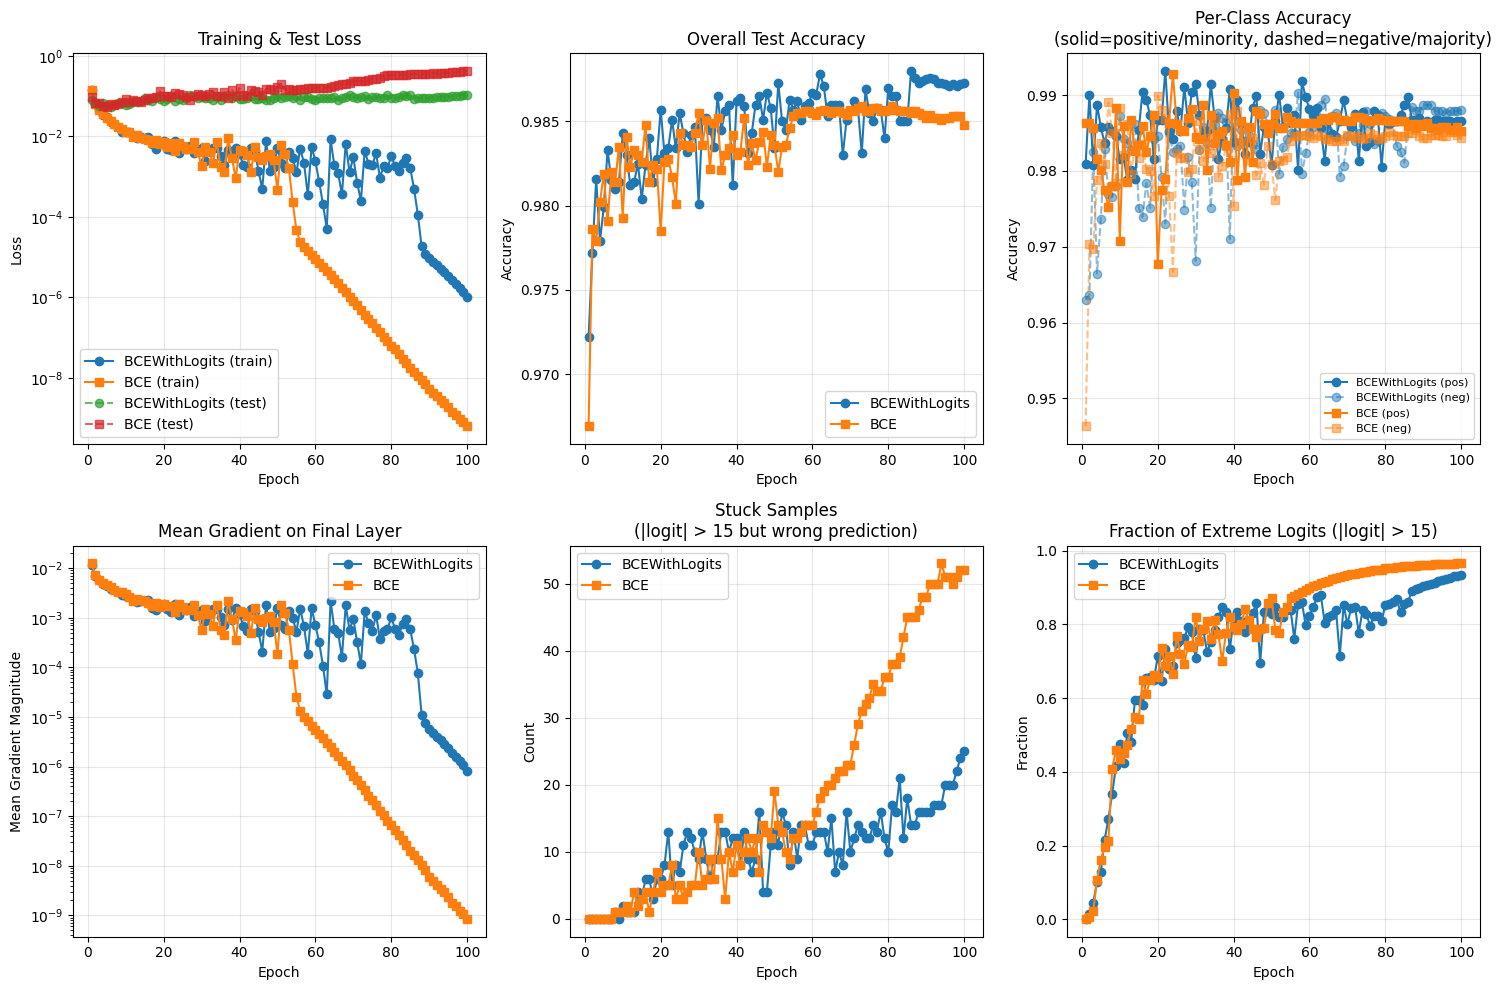

In [78]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

epochs_range = range(1, EPOCHS + 1)

# 1. Loss curves
ax = axes[0, 0]
ax.plot(epochs_range, history_bcewl['train_loss'], 'o-', label='BCEWithLogits (train)')
ax.plot(epochs_range, history_bce['train_loss'], 's-', label='BCE (train)')
ax.plot(epochs_range, history_bcewl['test_loss'], 'o--', label='BCEWithLogits (test)', alpha=0.7)
ax.plot(epochs_range, history_bce['test_loss'], 's--', label='BCE (test)', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.set_title('Training & Test Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Overall accuracy
ax = axes[0, 1]
ax.plot(epochs_range, history_bcewl['test_acc'], 'o-', label='BCEWithLogits')
ax.plot(epochs_range, history_bce['test_acc'], 's-', label='BCE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Overall Test Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Per-class accuracy
ax = axes[0, 2]
ax.plot(epochs_range, history_bcewl['test_acc_pos'], 'o-', label='BCEWithLogits (pos)', color='tab:blue')
ax.plot(epochs_range, history_bcewl['test_acc_neg'], 'o--', label='BCEWithLogits (neg)', color='tab:blue', alpha=0.5)
ax.plot(epochs_range, history_bce['test_acc_pos'], 's-', label='BCE (pos)', color='tab:orange')
ax.plot(epochs_range, history_bce['test_acc_neg'], 's--', label='BCE (neg)', color='tab:orange', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy\n(solid=positive/minority, dashed=negative/majority)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 4. Gradient magnitude
ax = axes[1, 0]
ax.plot(epochs_range, history_bcewl['grad_mean'], 'o-', label='BCEWithLogits')
ax.plot(epochs_range, history_bce['grad_mean'], 's-', label='BCE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Gradient Magnitude')
ax.set_yscale('log')
ax.set_title('Mean Gradient on Final Layer')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Stuck samples
ax = axes[1, 1]
ax.plot(epochs_range, history_bcewl['stuck_samples'], 'o-', label='BCEWithLogits')
ax.plot(epochs_range, history_bce['stuck_samples'], 's-', label='BCE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Count')
ax.set_title('Stuck Samples\n(|logit| > 15 but wrong prediction)')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Fraction of extreme logits
ax = axes[1, 2]
ax.plot(epochs_range, history_bcewl['grad_zero_frac'], 'o-', label='BCEWithLogits')
ax.plot(epochs_range, history_bce['grad_zero_frac'], 's-', label='BCE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Fraction')
ax.set_title('Fraction of Extreme Logits (|logit| > 15)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

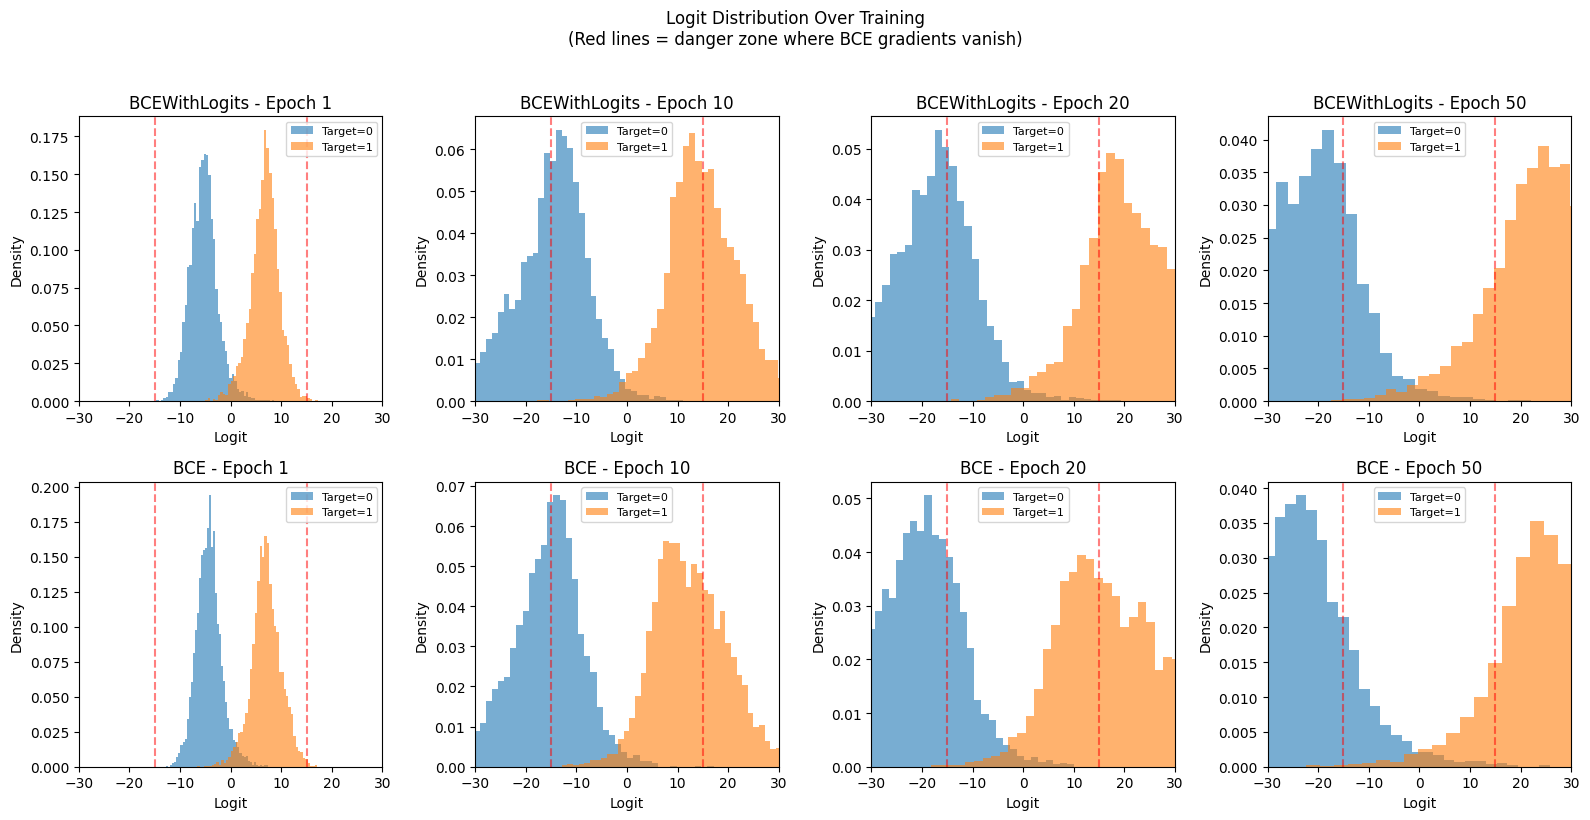

In [75]:
# Logit distribution over training
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

epochs_to_show = [0, 9, 19, 49]  # epoch indices

for i, ep in enumerate(epochs_to_show):
    # BCEWithLogits
    ax = axes[0, i]
    logits = history_bcewl['logits_all'][ep]
    targets = history_bcewl['targets_all'][ep]
    ax.hist(logits[targets == 0], bins=50, alpha=0.6, label='Target=0', density=True)
    ax.hist(logits[targets == 1], bins=50, alpha=0.6, label='Target=1', density=True)
    ax.axvline(x=15, color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=-15, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Logit')
    ax.set_ylabel('Density')
    ax.set_title(f'BCEWithLogits - Epoch {ep+1}')
    ax.legend(fontsize=8)
    ax.set_xlim(-30, 30)
    
    # BCE
    ax = axes[1, i]
    logits = history_bce['logits_all'][ep]
    targets = history_bce['targets_all'][ep]
    ax.hist(logits[targets == 0], bins=50, alpha=0.6, label='Target=0', density=True)
    ax.hist(logits[targets == 1], bins=50, alpha=0.6, label='Target=1', density=True)
    ax.axvline(x=15, color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=-15, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Logit')
    ax.set_ylabel('Density')
    ax.set_title(f'BCE - Epoch {ep+1}')
    ax.legend(fontsize=8)
    ax.set_xlim(-30, 30)

plt.suptitle('Logit Distribution Over Training\n(Red lines = danger zone where BCE gradients vanish)', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/jc/7dm_cdvn0759gz0xtck_ncvw0000gn/T/ipykernel_8748/3177199570.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


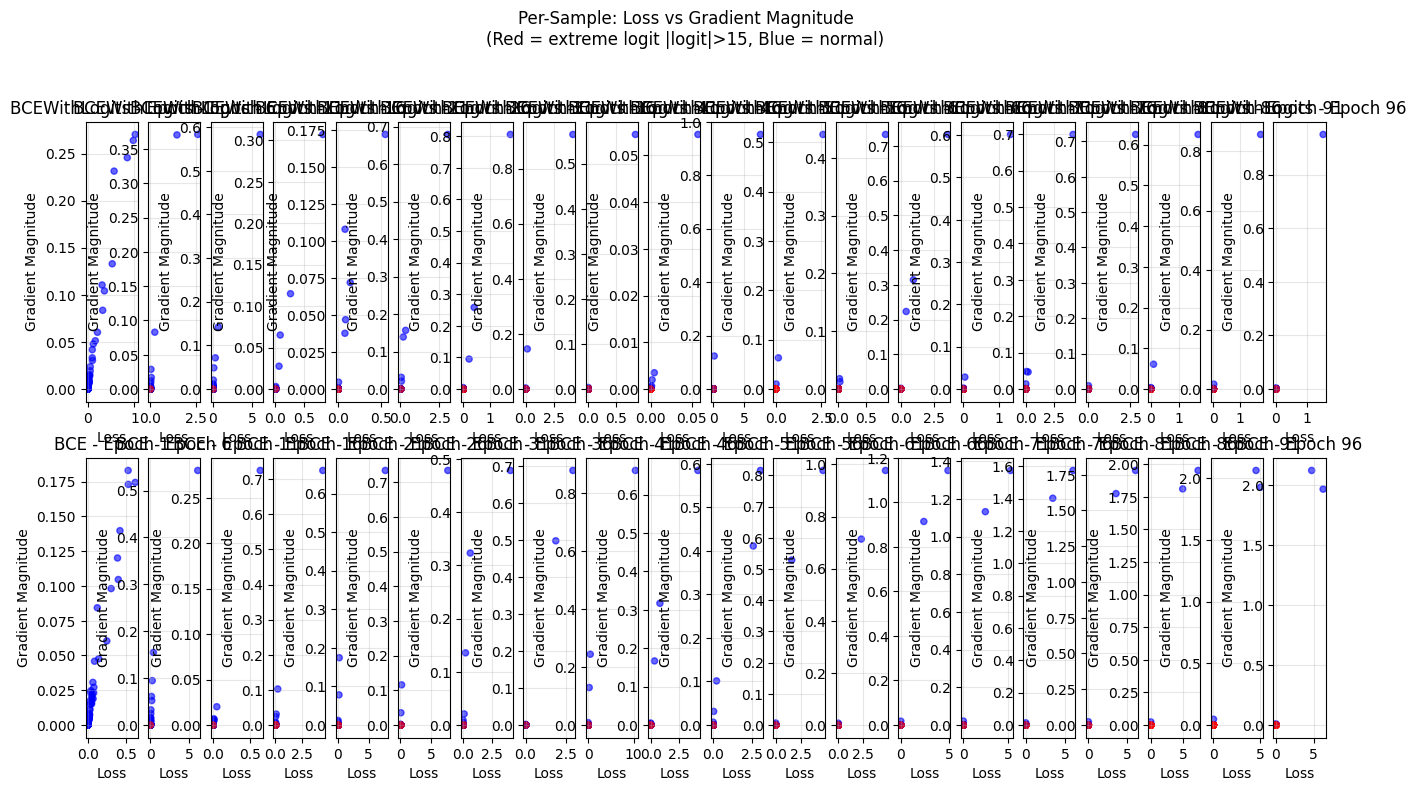

In [72]:
# Per-sample loss vs gradient (at different epochs)
fig, axes = plt.subplots(2, len(history_bcewl['sample_losses']), figsize=(16, 8))

sample_epochs = [i * 5 for i in range(len(history_bcewl['sample_losses']))]

for i, ep_idx in enumerate(range(len(history_bcewl['sample_losses']))):
    # BCEWithLogits
    ax = axes[0, i]
    losses = history_bcewl['sample_losses'][ep_idx]
    grads = history_bcewl['sample_grads'][ep_idx]
    logits_sample = history_bcewl['sample_logits'][ep_idx]
    targets = history_bcewl['sample_targets'][ep_idx]
    
    # Color by whether logit is extreme
    colors = ['red' if abs(l) > 15 else 'blue' for l in logits_sample]
    ax.scatter(losses, grads, c=colors, alpha=0.6, s=20)
    ax.set_xlabel('Loss')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_title(f'BCEWithLogits - Epoch {sample_epochs[i]+1}')
    ax.grid(True, alpha=0.3)
    
    # BCE
    ax = axes[1, i]
    losses = history_bce['sample_losses'][ep_idx]
    grads = history_bce['sample_grads'][ep_idx]
    logits_sample = history_bce['sample_logits'][ep_idx]
    
    colors = ['red' if abs(l) > 15 else 'blue' for l in logits_sample]
    ax.scatter(losses, grads, c=colors, alpha=0.6, s=20)
    ax.set_xlabel('Loss')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_title(f'BCE - Epoch {sample_epochs[i]+1}')
    ax.grid(True, alpha=0.3)

plt.suptitle('Per-Sample: Loss vs Gradient Magnitude\n(Red = extreme logit |logit|>15, Blue = normal)', y=1.02)
plt.tight_layout()
plt.show()

In [73]:
# Summary statistics
print("=" * 70)
print("SUMMARY COMPARISON")
print("=" * 70)

print(f"\n{'Metric':<30} | {'BCEWithLogits':>15} | {'BCE':>15}")
print("-" * 70)
print(f"{'Final Test Accuracy':<30} | {history_bcewl['test_acc'][-1]:>15.4f} | {history_bce['test_acc'][-1]:>15.4f}")
print(f"{'Final Pos Class Accuracy':<30} | {history_bcewl['test_acc_pos'][-1]:>15.4f} | {history_bce['test_acc_pos'][-1]:>15.4f}")
print(f"{'Final Neg Class Accuracy':<30} | {history_bcewl['test_acc_neg'][-1]:>15.4f} | {history_bce['test_acc_neg'][-1]:>15.4f}")
print(f"{'Final Train Loss':<30} | {history_bcewl['train_loss'][-1]:>15.4f} | {history_bce['train_loss'][-1]:>15.4f}")
print(f"{'Final Test Loss':<30} | {history_bcewl['test_loss'][-1]:>15.4f} | {history_bce['test_loss'][-1]:>15.4f}")
print(f"{'Final Stuck Samples':<30} | {history_bcewl['stuck_samples'][-1]:>15d} | {history_bce['stuck_samples'][-1]:>15d}")
print(f"{'Final Extreme Logit Fraction':<30} | {history_bcewl['grad_zero_frac'][-1]:>15.4f} | {history_bce['grad_zero_frac'][-1]:>15.4f}")
print(f"{'Mean Gradient (final epoch)':<30} | {history_bcewl['grad_mean'][-1]:>15.6f} | {history_bce['grad_mean'][-1]:>15.6f}")

# Check for logit explosion
max_logit_bcewl = max(abs(history_bcewl['logits_all'][-1]).max(), abs(history_bcewl['logits_all'][-1]).min())
max_logit_bce = max(abs(history_bce['logits_all'][-1]).max(), abs(history_bce['logits_all'][-1]).min())
print(f"{'Max |logit| (final epoch)':<30} | {max_logit_bcewl:>15.2f} | {max_logit_bce:>15.2f}")

SUMMARY COMPARISON

Metric                         |   BCEWithLogits |             BCE
----------------------------------------------------------------------
Final Test Accuracy            |          0.9873 |          0.9848
Final Pos Class Accuracy       |          0.9866 |          0.9852
Final Neg Class Accuracy       |          0.9881 |          0.9844
Final Train Loss               |          0.0000 |          0.0000
Final Test Loss                |          0.1066 |          0.4196
Final Stuck Samples            |              25 |              52
Final Extreme Logit Fraction   |          0.9348 |          0.9650
Mean Gradient (final epoch)    |        0.000001 |        0.000000
Max |logit| (final epoch)      |          111.30 |          152.13


In [77]:
# Analyze wrong predictions in detail
print("=" * 70)
print("ANALYSIS OF WRONG PREDICTIONS (Final Epoch)")
print("=" * 70)

for name, history in [("BCEWithLogits", history_bcewl), ("BCE", history_bce)]:
    logits = history['logits_all'][-1]
    targets = history['targets_all'][-1]
    preds = (1 / (1 + np.exp(-logits)) > 0.5).astype(float)
    wrong = preds != targets
    
    print(f"\n{name}:")
    print(f"  Total wrong predictions: {wrong.sum()}")
    
    # Wrong predictions by logit magnitude
    wrong_logits = logits[wrong]
    if len(wrong_logits) > 0:
        print(f"  Wrong predictions with |logit| > 15: {(np.abs(wrong_logits) > 15).sum()}")
        print(f"  Wrong predictions with |logit| > 10: {(np.abs(wrong_logits) > 10).sum()}")
        print(f"  Mean |logit| of wrong predictions: {np.abs(wrong_logits).mean():.2f}")
        print(f"  Max |logit| of wrong predictions: {np.abs(wrong_logits).max():.2f}")
        
        # Breakdown by class
        wrong_pos = wrong & (targets == 1)  # False negatives
        wrong_neg = wrong & (targets == 0)  # False positives
        print(f"  False negatives (target=1, pred=0): {wrong_pos.sum()}")
        print(f"  False positives (target=0, pred=1): {wrong_neg.sum()}")

ANALYSIS OF WRONG PREDICTIONS (Final Epoch)

BCEWithLogits:
  Total wrong predictions: 127
  Wrong predictions with |logit| > 15: 25
  Wrong predictions with |logit| > 10: 36
  Mean |logit| of wrong predictions: 8.28
  Max |logit| of wrong predictions: 37.91
  False negatives (target=1, pred=0): 69
  False positives (target=0, pred=1): 58

BCE:
  Total wrong predictions: 152
  Wrong predictions with |logit| > 15: 52
  Wrong predictions with |logit| > 10: 71
  Mean |logit| of wrong predictions: 12.87
  Max |logit| of wrong predictions: 58.02
  False negatives (target=1, pred=0): 76
  False positives (target=0, pred=1): 76


/var/folders/jc/7dm_cdvn0759gz0xtck_ncvw0000gn/T/ipykernel_8748/3141349081.py:9: RuntimeWarning: overflow encountered in exp
  preds = (1 / (1 + np.exp(-logits)) > 0.5).astype(float)
